In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import random
import math
from timeit import default_timer as timer

In [2]:
inputString = '''
1 1 1
1 6 1
2 1 2
3 9 2
3 10 2
4 6 1
5 6 2
7 2 2
8 1 1
8 9 1
9 1 1
9 9 1
9 10 2
10 3 1
10 5 2
'''
dataFromStr = [[int(e) for e in textline.split(' ')] for textline in inputString.strip().split('\n')]

In [3]:
dataFromStr

[[1, 1, 1],
 [1, 6, 1],
 [2, 1, 2],
 [3, 9, 2],
 [3, 10, 2],
 [4, 6, 1],
 [5, 6, 2],
 [7, 2, 2],
 [8, 1, 1],
 [8, 9, 1],
 [9, 1, 1],
 [9, 9, 1],
 [9, 10, 2],
 [10, 3, 1],
 [10, 5, 2]]

In [4]:
E1 = [tuple(row[:-1]) for row in dataFromStr if row[2]==1]
E2 = [tuple(row[:-1]) for row in dataFromStr if row[2]==2]
print(E1)
print(E2)

[(1, 1), (1, 6), (4, 6), (8, 1), (8, 9), (9, 1), (9, 9), (10, 3)]
[(2, 1), (3, 9), (3, 10), (5, 6), (7, 2), (9, 10), (10, 5)]


In [5]:
inputString = '''
1 1 
1 6 
2 1 
3 9 
3 10
4 6 
5 6 
7 2 
8 1 
8 9 
9 1 
9 9 
9 10 
10 3 
10 5 
'''
dataFromStrNoClass = [[int(e) for e in textline.strip().split(' ')] for textline in inputString.strip().split('\n')]

In [6]:
dataFromStrNoClass

[[1, 1],
 [1, 6],
 [2, 1],
 [3, 9],
 [3, 10],
 [4, 6],
 [5, 6],
 [7, 2],
 [8, 1],
 [8, 9],
 [9, 1],
 [9, 9],
 [9, 10],
 [10, 3],
 [10, 5]]

In [7]:
df = pd.DataFrame(
    data=dataFromStr,
    columns=['x','y','label']
)

In [8]:
df

,x,y,label
0,1,1,1
1,1,6,1
2,2,1,2
3,3,9,2
4,3,10,2
5,4,6,1
6,5,6,2
7,7,2,2
8,8,1,1
9,8,9,1


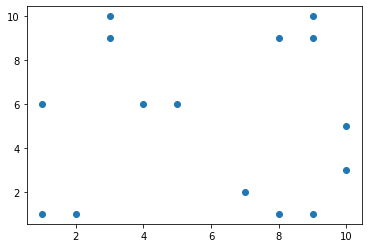

In [9]:
fig, ax = plt.subplots(1,1)

# ax.scatter(x=df['x'], y=df['y'])

ax.scatter(df['x'], df['y'])


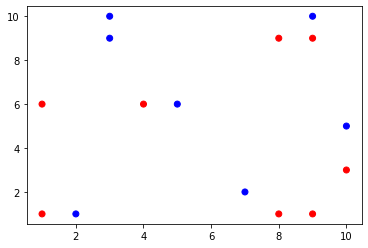

In [10]:
fig, ax = plt.subplots(1,1)

colors = {1: 'red', 2: 'blue'}

# ax.scatter(x=df['x'], y=df['y'])

ax.scatter(df['x'], df['y'], c=df['label'].map(colors))

In [11]:
def get_initial_means(array, k=2, method='rand'):
    """
    Picks k random points from the 2D array 
    (without replacement) to use as initial 
    cluster means

    params:
    array = numpy.ndarray[numpy.ndarray[float]] - m x n | datapoints x features

    k = int

    returns:
    initial_means = numpy.ndarray[numpy.ndarray[float]]
    """
    # TODO: finish this function
    if method != 'rand':
        e1_points = df[df['label']==1]
        e2_points = df[df['label']==2]

        e1_xMean = e1_points['x'].mean()
        e1_yMean = e1_points['y'].mean()

        e2_xMean = e2_points['x'].mean()
        e2_yMean = e2_points['y'].mean()

        meanOfE1 = (e1_xMean, e1_yMean)
        meanOfE2 = (e2_xMean, e2_yMean)
        ret = [
            meanOfE1,
            meanOfE2
        ]
    else:
        # ret = [
            # [random.randint(1,10),random.randint(1,10)], # x,y of point 1
            # [random.randint(1,10),random.randint(1,10)],
            # [random.randint(1,10),random.randint(1,10)],
        # ]
        ret = random.sample(array, k=3)
    return np.array(ret)



In [12]:
initMeans = get_initial_means(dataFromStrNoClass)
initMeans

array([[ 9,  1],
       [ 8,  1],
       [10,  3]])

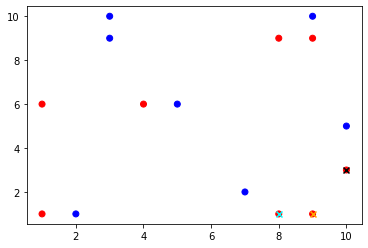

In [13]:
fig, ax = plt.subplots(1,1)

colors = {1: 'red', 2: 'blue'}

ax.scatter(df['x'], df['y'], c=df['label'].map(colors))
ax.scatter([initMeans[0][0]], [initMeans[0][1]], marker='x',c='orange')
ax.scatter([initMeans[1][0]], [initMeans[1][1]], marker='x',c='cyan')
ax.scatter([initMeans[2][0]], [initMeans[2][1]], marker='x',c='black')

In [14]:
def k_means_step(X, k, means, DEBUG=False):
    """
    A single update/step of the K-means algorithm
    Based on a input X and current mean estimates,
    predict clusters for each of the examples in X and 
    calculate new means. 
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n | pixels x features (already flattened)
        (15,2)
    k = int
    means = numpy.ndarray[numpy.ndarray[float]] - k x n
        (2,2)

    returns:
    (new_means, clusters)
    new_means = numpy.ndarray[numpy.ndarray[float]] - k x n
    clusters = numpy.ndarray[int] - m sized vector
    """
    dataset = X

    if DEBUG:
        print('====== BEGIN K_M STEP ======')
        print('Step 2: Map points to closest init-cluster-mean by Euclidean Distance')
        print(f'Dists from each point to each Init-Centroid in the format of [point] -> (cluster label, dist to that cluster\'s centroid):')
    
    pointToCluster = {} # x,y point example from dataset -> cluster label
    for point in dataset:
        dists = [( round(np.linalg.norm(point-means[i]),3), i) for i in range(k)]
        
        if DEBUG:
            print(f'{point} : {[(l,d) for d,l in dists]}')
        
        bestDist = min(dists)
        closestClusterLabel = bestDist[1]
        pointToCluster[tuple(point.tolist())] = closestClusterLabel
    
    if DEBUG:
        print('\nPoint to Cluster Assignments:')
        print(pointToCluster)
        print('-'*15)
        print('Step 3: Calculate Covariance Matrix for each Cluster')
    
    # Step 3: Covar Mtx for each Cluster
    covMatricies = {} # clusterLabel -> cov
    clusterSizes = {} # clusterLabel -> cluster size
    clusterLabels = set(pointToCluster.values())
    for clusterLabel in clusterLabels: # 1,2,3
        points = {
            point:label
            for point, label in pointToCluster.items()
            if label == clusterLabel
        }
        if DEBUG:
            print(f'Points in Cluster {clusterLabel}:', points)
        listOfThisClustersPoints = list(points.keys())

        x_values, y_values = zip(*listOfThisClustersPoints)
        covdata = np.vstack((x_values, y_values))
        thisClustersCOV = np.cov(covdata, bias=True)
        
        covMatricies[clusterLabel] = thisClustersCOV
        clusterSizes[clusterLabel] = len(listOfThisClustersPoints)
    # end for each cluster, get COV
    
    if DEBUG:
        print('\nCovariance Matricies:')
        for clusterLabel,cov in covMatricies.items():
            print('Covariance Matrix of Cluster', clusterLabel)
            print(cov)
            print()
        print('Number of Points in Each Cluster:')
        print(clusterSizes)
        print('-'*15)
        # print('inverse COV matrices')
        print("\nStep 4 Setup: Calculate required inverse covariance matricies and Cluster Means")
    
    # Step 4 Setup: Calculate required inv-cov-mtx's and Cluster Means
    inverseCOVs = {}
    for clusterLabel,cov in covMatricies.items():
        inv = np.linalg.inv(cov)
        inverseCOVs[clusterLabel] = inv * -1
        if DEBUG:
            print(f'Cluster {clusterLabel} Inverse Covariance Matrix')
            print(inverseCOVs[clusterLabel])
    
    if DEBUG:
        print('-'*7)
        print('Cluster Means')
    
    clusterMeans = {} # clusterLabel -> [x_mean, y_mean]
    for clusterLabel in clusterLabels:
        clusterPoints = [point for point,cluster in pointToCluster.items() if cluster==clusterLabel]
        clusterMean = np.mean(clusterPoints, axis=0)
        clusterMeans[clusterLabel] = clusterMean
        if DEBUG:
            print('\nCluster', clusterLabel)
            print('Points', clusterPoints)
            print('XY Mean', clusterMean)
    if DEBUG:
        print('-'*15)
        print('Step 4: For each Observation, calculate MH distance to each cluster')
        print()
    
    def mahaDist(point, clusterLabel, DEBUG=True):
        meanDiff = point - clusterMeans[clusterLabel] # v-m
        tempMtx = np.matmul(meanDiff, covMatricies[clusterLabel])
        sqDist = np.matmul(tempMtx, np.transpose(tempMtx))
        finalMHdist = math.sqrt(sqDist)
        if DEBUG:
            print(f'Mahalanobis Dist for {point} to cluster {clusterLabel}')
            print('Mean Feature Difference')
            print(meanDiff)
            print('Cluster Inverse Covariance Matrix')
            print(covMatricies[clusterLabel])
            print('MDV * ICOV = Temp Matrix')
            print(tempMtx)
            print('Temp_Transpose * Temp = Square Distance')
            print(sqDist)
            print('final MH dist')
            print(finalMHdist)
            print()
        return finalMHdist
    
    # Step 4 & 5: For each point, calculate MD dist to each cluster
    #             Then, assign to min-dist cluster label
    pointToCluster = {} # x,y point example from dataset -> cluster label
    for point in dataset:  
        if DEBUG:
            print()
            print('-'*3,'MH distances for point', point)
        dists = [
            ( mahaDist(point, clusterLabel), clusterLabel )
            for clusterLabel in clusterLabels
        ]
        bestDist = min(dists)
        closestClusterLabel = bestDist[1]
        pointToCluster[tuple(point.tolist())] = closestClusterLabel
        if DEBUG:
            print(f'Point {point} To Cluster MH Distances: {[(l,round(d,3)) for d,l in dists]}')
    
            
    if DEBUG:
        print('\nPoint to Cluster Assignments After Min-MH-Distance Reassignment:')
        print(pointToCluster)
    
    curClusters = [
        [point for point,label in pointToCluster.items() if label==clusterLabel]
        for clusterLabel in clusterLabels
    ]
#     print( list(clusterMeans.values()) )
#     print(curClusters)
    
    return list(clusterMeans.values()), curClusters

In [16]:
def k_means_segment(dataset, k=2, initial_means=None, DEBUG=False):
    if initial_means is None:
        print('creating initial means...')
        initial_means = get_initial_means(dataset, k)
    
    if DEBUG:
        print('init means')
        print(initial_means)
        print('-'*15)

    print('1st call to k_means')
    curMeans, curClusters = k_means_step(dataset, k, initial_means, DEBUG=True)
    vizIter(curMeans, curClusters)
    if DEBUG:
        print('curMeans')
        print(curMeans)
        print('curClusters')
        print(curClusters)
        print()
    
    iterStyle = 2
    if iterStyle == 2:
        print('2nd call to k_means')
        curMeans, curClusters = k_means_step(dataset, k, curMeans, DEBUG=True)
        vizIter(curMeans, curClusters)
        prevClusters = tuple([tuple(c) for c in curClusters])
    else:
        prevClusters = tuple([tuple(c) for c in curClusters])
        for i in range(10):
            curMeans, curClusters = k_means_step(dataset, k, curMeans, DEBUG=True)
            vizIter(curMeans, curClusters)
            if prevClusters == tuple([tuple(c) for c in curClusters]):
                break
            prevClusters = tuple([tuple(c) for c in curClusters])
    
    if DEBUG:
        print('====== END K_M STEPPING ======')
        print('curMeans')
        print(curMeans)
        print('curClusters')
        print(curClusters)
    
    return curMeans, prevClusters

In [17]:
def vizIter(curMeans, clusterData):
    fig, ax = plt.subplots(1,1)
    colors = ['red','blue','green']
    for i,clusterXYs in enumerate(clusterData):
        xValues_e1 = [xy[0] for xy in clusterXYs if xy in E1]
        yValues_e1 = [xy[1] for xy in clusterXYs if xy in E1]
        ax.scatter(xValues_e1, yValues_e1,
                   marker='*', c=colors[i], label=f'Cluster {i}, E1')
        
        xValues_e2 = [xy[0] for xy in clusterXYs if xy in E2]
        yValues_e2 = [xy[1] for xy in clusterXYs if xy in E2]
        ax.scatter(xValues_e2, yValues_e2,
                   marker='+', c=colors[i], label=f'Cluster {i}, E2')
        
        thisMean = curMeans[i]
        ax.scatter([thisMean[0]], [thisMean[1]], marker='x', c=colors[i], label=f'Cluster {i} Centroid')
#     fig.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
    return

In [18]:
def vizInit(datapoints, initMeans):
    if type(initMeans) != list:
        initMeans = initMeans.tolist()
    
    datapoints = [d for d in datapoints if d not in initMeans]
    
    fig, ax = plt.subplots(1,1)
    
    xValues = [xy[0] for xy in datapoints]
    yValues = [xy[1] for xy in datapoints]
    ax.scatter(xValues, yValues)
    
    mean_xs = [xy[0] for xy in initMeans]
    mean_ys = [xy[1] for xy in initMeans]
    ax.scatter(mean_xs, mean_ys, c='red', label='Cluster Centroid')
    
    fig.legend()
    fig.suptitle('Initial Centroids of Clusters')
    plt.tight_layout()
    plt.show()
    return

In [19]:
initMeans_LucioFGC = [
    (2, 1),
    (7, 2),
    (9, 10)
]
initMeans = get_initial_means(dataFromStrNoClass)

In [20]:
initMeans = [
    [ 1,  1],
    [ 3,  9],
    [ 9, 10]
]
print(initMeans)

[[1, 1], [3, 9], [9, 10]]


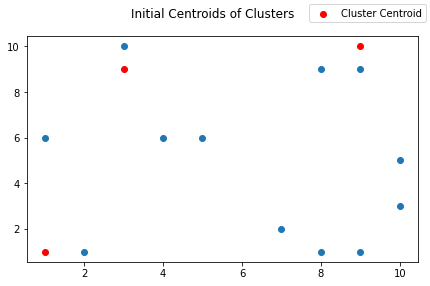

In [21]:
vizInit(dataFromStrNoClass, initMeans)

init means
[[1, 1], [3, 9], [9, 10]]
---------------
1st call to k_means
====== BEGIN K_M STEP ======
Step 2: Map points to closest init-cluster-mean by Euclidean Distance
Dists from each point to each Init-Centroid in the format of [point] -> (cluster label, dist to that cluster's centroid):
[1 1] : [(0, 0.0), (1, 8.246), (2, 12.042)]
[1 6] : [(0, 5.0), (1, 3.606), (2, 8.944)]
[2 1] : [(0, 1.0), (1, 8.062), (2, 11.402)]
[3 9] : [(0, 8.246), (1, 0.0), (2, 6.083)]
[ 3 10] : [(0, 9.22), (1, 1.0), (2, 6.0)]
[4 6] : [(0, 5.831), (1, 3.162), (2, 6.403)]
[5 6] : [(0, 6.403), (1, 3.606), (2, 5.657)]
[7 2] : [(0, 6.083), (1, 8.062), (2, 8.246)]
[8 1] : [(0, 7.0), (1, 9.434), (2, 9.055)]
[8 9] : [(0, 10.63), (1, 5.0), (2, 1.414)]
[9 1] : [(0, 8.0), (1, 10.0), (2, 9.0)]
[9 9] : [(0, 11.314), (1, 6.0), (2, 1.0)]
[ 9 10] : [(0, 12.042), (1, 6.083), (2, 0.0)]
[10  3] : [(0, 9.22), (1, 9.22), (2, 7.071)]
[10  5] : [(0, 9.849), (1, 8.062), (2, 5.099)]

Point to Cluster Assignments:
{(1, 1): 0, (1, 6)

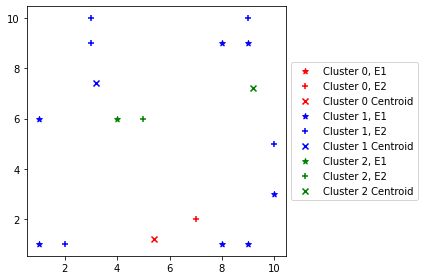

curMeans
[array([5.4, 1.2]), array([3.2, 7.4]), array([9.2, 7.2])]
curClusters
[[(7, 2)], [(1, 1), (1, 6), (2, 1), (3, 9), (3, 10), (8, 1), (8, 9), (9, 1), (9, 9), (9, 10), (10, 3), (10, 5)], [(4, 6), (5, 6)]]

2nd call to k_means
====== BEGIN K_M STEP ======
Step 2: Map points to closest init-cluster-mean by Euclidean Distance
Dists from each point to each Init-Centroid in the format of [point] -> (cluster label, dist to that cluster's centroid):
[1 1] : [(0, 4.405), (1, 6.768), (2, 10.28)]
[1 6] : [(0, 6.512), (1, 2.608), (2, 8.287)]
[2 1] : [(0, 3.406), (1, 6.512), (2, 9.502)]
[3 9] : [(0, 8.161), (1, 1.612), (2, 6.456)]
[ 3 10] : [(0, 9.121), (1, 2.608), (2, 6.803)]
[4 6] : [(0, 5.0), (1, 1.612), (2, 5.337)]
[5 6] : [(0, 4.817), (1, 2.28), (2, 4.368)]
[7 2] : [(0, 1.789), (1, 6.603), (2, 5.646)]
[8 1] : [(0, 2.608), (1, 8.0), (2, 6.315)]
[8 9] : [(0, 8.222), (1, 5.06), (2, 2.163)]
[9 1] : [(0, 3.606), (1, 8.637), (2, 6.203)]
[9 9] : [(0, 8.591), (1, 6.017), (2, 1.811)]
[ 9 10] : [(

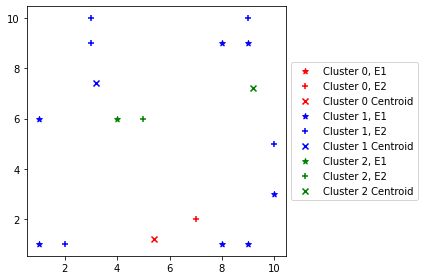

====== END K_M STEPPING ======
curMeans
[array([5.4, 1.2]), array([3.2, 7.4]), array([9.2, 7.2])]
curClusters
[[(7, 2)], [(1, 1), (1, 6), (2, 1), (3, 9), (3, 10), (8, 1), (8, 9), (9, 1), (9, 9), (9, 10), (10, 3), (10, 5)], [(4, 6), (5, 6)]]


In [22]:
startTime = timer()
k_means_segment(np.array(dataFromStrNoClass),
                k=3,
                initial_means=initMeans,
                DEBUG=True
)
stopTime = timer()

In [23]:
print(stopTime - startTime, 'seconds to perform 2 iterations of K-Means Clustering with Mahalanobis Distance')

0.21274760000000015 seconds to perform 2 iterations of K-Means Clustering with Mahalanobis Distance
